# Xente Fraud Detection Challenge

http://zindi.africa/competitions/xente-fraud-detection-challenge

The objective of this competition is to create a machine learning model to detect fraudulent transactions.

The error metric for this competition is the F1 score, which ranges from 0 (total failure) to 1 (perfect score). Hence, the closer your score is to 1, the better your model.

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import tree, linear_model, svm, neighbors, naive_bayes, neural_network, ensemble, gaussian_process, discriminant_analysis
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, auc, precision_recall_curve

### Exploratory Data Analysis

In [43]:
training = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
training.isnull().values.any()

False

There are no missing values in the training set.

In [44]:
training.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


### Feature Definitions
| Feature Name          | Definition                                                                                                        |
|----------------------|-------------------------------------------------------------------------------------------------------------------|
| TransactionId        | Unique transaction identifier on platform                                                                      |
| BatchId              | Unique number assigned to a batch of transactions for processing                                                  |
| AccountId            | Unique number identifying the customer on platform                                                                |
| SubscriptionId       | Unique number identifying the customer subscription                                                               |
| CustomerId           | Unique identifier attached to Account                                                                             |
| CurrencyCode         | Country currency                                                                                                  |
| CountryCode          | Numerical geographical code of country                                                                            |
| ProviderId           | Source provider of Item ÔøΩbought.                                                                                |
| ProductId            | Item name being bought.                                                                                           |
| ProductCategory      | ProductIds are organized into these broader product categories.                                                   |
| ChannelId            | Identifies if customer used web,Android, IOS, pay later or checkout.                                              |
| Amount               | Value of the transaction. Positive for debits from customer account and negative for credit into customer account |
| Value                | Absolute value of the amount                                                                                      |
| TransactionStartTime | Transaction start time                                                                                            |
| PricingStrategy      | Category of Xente's pricing structure for merchants                                                               |
| FraudResult          | Fraud status of transaction 1 -yes or 0-No                                                                        |

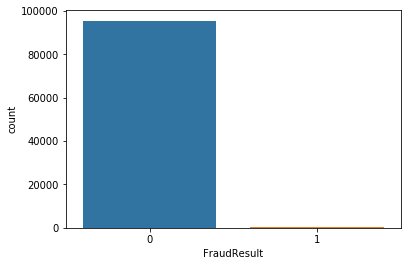

In [45]:
sns.countplot("FraudResult", data=training)
plt.show()

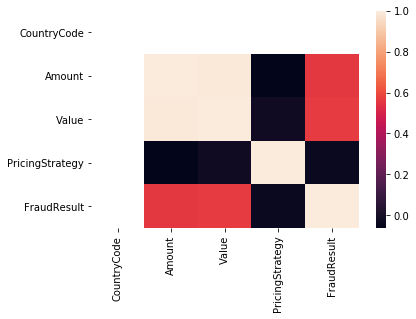

In [46]:
sns.heatmap(training.corr())
plt.show()

Currently only 4 numerical variables can be correlated. The only variables with correlation are Value and Amount, because Amount is the modulus of Value.

### Feature Engineering
Features added:
- One-hot encoded features for all categorical variables
- Withdrawal / deposit boolean
- Difference in transaction value with previous transaction made by same account (first transactions filled with mean value)
- Time since previous transaction made by same account (first transactions filled with mean value)
- Difference between transaction amount/value and average account amount/value
	- stratified by Category
	- stratified by Provider
	- stratified by Product
	- Stratified by Channel
- Difference from average account transaction time (hour)
- Total account transactions in same hour
- Decomposition of DateTime feature (Hour, Day of week, Day)
- Difference from average overall transaction time
	- stratified by Category / Provider / Product / Channel

In [47]:
training = pd.read_csv('training.csv')
knownfraud = list(training[training['FraudResult'] == 1]['AccountId'])

def add_features(df):
    
    # Store index
    idx = df.index
    
    df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
    training['Time'] = training['TransactionStartTime'].dt.hour * 60 + training['TransactionStartTime'].dt.minute
    
    for col in ('ProviderId', 'ProductId', 'ProductCategory', 'ChannelId'):
         for_dummy = df[col]
         df = pd.concat([df, pd.get_dummies(for_dummy, prefix=col)], axis=1)
    
    # Difference with previous transaction amount
    
    df = df.sort_values(['AccountId', 'TransactionStartTime'], ascending=True)

    df['Difference from previous transaction'] = df['Amount'].diff()
    mask = df['AccountId'] != df['AccountId'].shift(1)
    df['Difference from previous transaction'][mask] = np.nan
    df['Difference from previous transaction'] = df['Difference from previous transaction'].fillna(df['Difference from previous transaction'].mean())

    # Difference with previous transaction time

    df['Time difference from previous transaction'] = df['TransactionStartTime'].diff()
    mask = df['AccountId'] != df['AccountId'].shift(1)
    df['Time difference from previous transaction'][mask] = np.nan
    df['Time difference from previous transaction'] = df['Time difference from previous transaction'].fillna(df['Time difference from previous transaction'].mean())

    df['DateNum'] = pd.to_numeric(df['Time difference from previous transaction'])

    # Difference from average account transaction

    df['Difference from Average Account'] = df.groupby('AccountId')['Value'].transform(lambda x: (x - x.mean()))
    
    # Difference from average account transaction by ProductCategory / ProviderId / ProductId
    
    df['CategoryDiffV'] = df.groupby(['AccountId', 'ProductCategory'])['Value'].transform(lambda x: (x - x.mean()))
    df['CategoryDiffA'] = df.groupby(['AccountId', 'ProductCategory'])['Amount'].transform(lambda x: (x - x.mean()))
    df['ProviderDiffV'] = df.groupby(['AccountId', 'ProviderId'])['Value'].transform(lambda x: (x - x.mean()))
    df['ProviderDiffA'] = df.groupby(['AccountId', 'ProviderId'])['Amount'].transform(lambda x: (x - x.mean()))
    df['ProductDiffV'] = df.groupby(['AccountId', 'ProductId'])['Value'].transform(lambda x: (x - x.mean()))
    df['ProductDiffA'] = df.groupby(['AccountId', 'ProductId'])['Amount'].transform(lambda x: (x - x.mean()))
    
    # Difference from average account hour
    df['Hour'] = df['TransactionStartTime'].dt.hour
    df['DayofWeek'] = df['TransactionStartTime'].dt.weekday
    df['Difference from Average Time'] = df.groupby('AccountId')['Hour'].transform(lambda x: (x - x.mean()))
    
    #Overall averages
    df['Difference from Average Time Overall'] = df['Hour'].transform(lambda x: (x - x.mean()))
    df['CategoryDiffOverallV'] = df.groupby(['ProductCategory'])['Value'].transform(lambda x: (x - x.mean()))
    df['CategoryDiffOverallA'] = df.groupby(['ProductCategory'])['Amount'].transform(lambda x: (x - x.mean()))
    df['ProviderDiffOverallV'] = df.groupby(['ProviderId'])['Value'].transform(lambda x: (x - x.mean()))
    df['ProviderDiffOverallA'] = df.groupby(['ProviderId'])['Amount'].transform(lambda x: (x - x.mean()))
    df['ProductDiffOverallV'] = df.groupby(['ProviderId'])['Value'].transform(lambda x: (x - x.mean()))
    df['ProductDiffOverallA'] = df.groupby(['ProviderId'])['Amount'].transform(lambda x: (x - x.mean()))
    
    df = df.reindex(idx)
    
    return df
    
training = add_features(training)

/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Further Visualisation

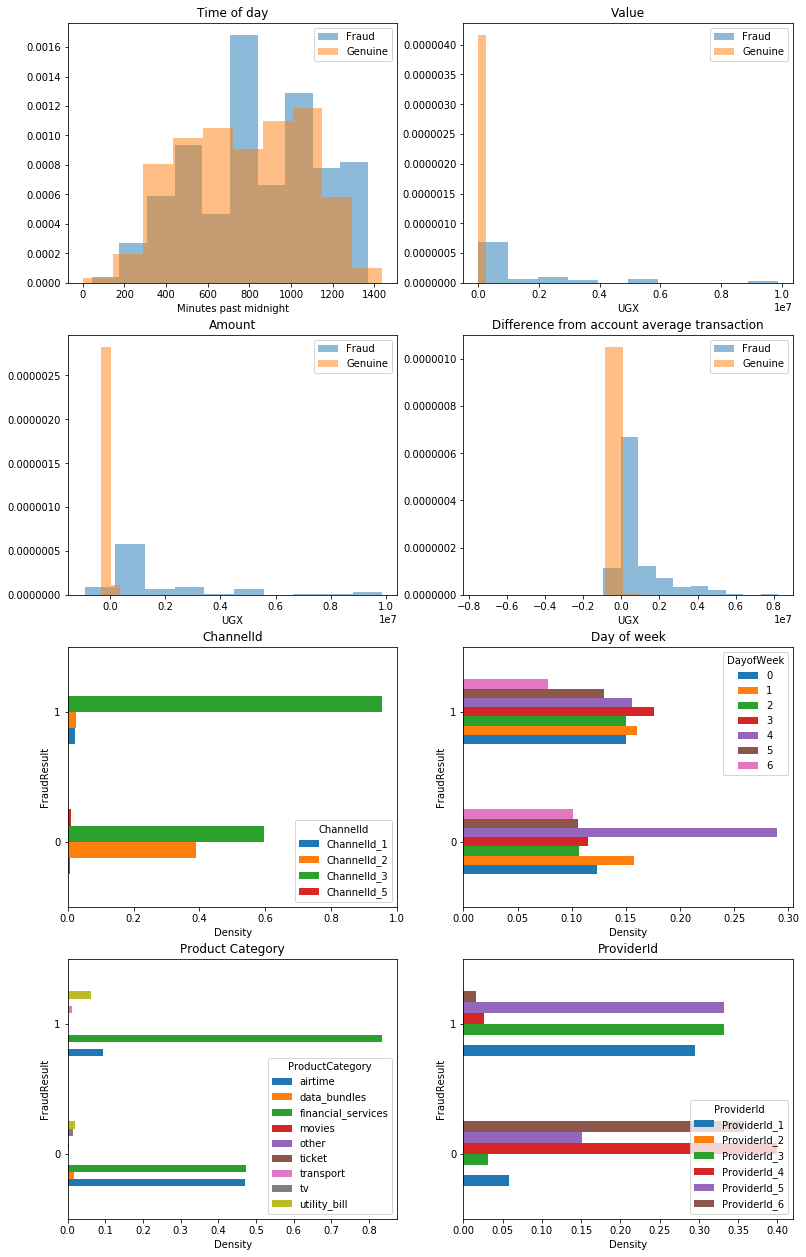

In [48]:
fraud = training[training['FraudResult'] == 1]
genuine = training[training['FraudResult'] == 0]

fig = plt.figure(figsize=(13,22))

plt.subplot(421)
plt.title('Time of day')
plt.hist(fraud['Time'], density=True, alpha=0.5)
plt.hist(genuine['Time'], density=True, alpha=0.5)
plt.xlabel('Minutes past midnight')
plt.legend(['Fraud', 'Genuine'])

plt.subplot(422)
plt.title('Value')
plt.hist(fraud['Value'], density=True, alpha=0.5)
plt.hist(genuine['Value'], density=True, alpha=0.5)
plt.xlabel('UGX')
plt.legend(['Fraud', 'Genuine'])

plt.subplot(423)
plt.title('Amount')
plt.hist(fraud['Amount'], density=True, alpha=0.5)
plt.hist(genuine['Amount'], density=True, alpha=0.5)
plt.xlabel('UGX')
plt.legend(['Fraud', 'Genuine'])

plt.subplot(424)
plt.title('Difference from account average transaction')
plt.hist(fraud['Difference from Average Account'], density=True, alpha=0.5)
plt.hist(genuine['Difference from Average Account'], density=True, alpha=0.5)
plt.xlabel('UGX')
plt.legend(['Fraud', 'Genuine'])

ax1 = fig.add_subplot(425)
data = training.groupby('FraudResult')['ChannelId'].value_counts(normalize=True).unstack()
data.plot(kind='barh', ax=ax1)
plt.title('ChannelId')
plt.xlabel('Density')

ax2 = fig.add_subplot(426)
data = training.groupby('FraudResult')['DayofWeek'].value_counts(normalize=True).unstack()
data.plot(kind='barh', ax=ax2)
plt.title('Day of week')
plt.xlabel('Density')

ax3 = fig.add_subplot(427)
data = training.groupby('FraudResult')['ProductCategory'].value_counts(normalize=True).unstack()
data.plot(kind='barh', ax=ax3)
plt.title('Product Category')
plt.xlabel('Density')

ax3 = fig.add_subplot(428)
data = training.groupby('FraudResult')['ProviderId'].value_counts(normalize=True).unstack()
data.plot(kind='barh', ax=ax3)
plt.title('ProviderId')
plt.xlabel('Density')



plt.show()

Observations:
- Relatively more fraudulent transactions seem to be made via ChannelId_3, which is the iOS operating system
- There is a spike in genuine transactions on weekday 4 (Friday), not seen in fraudulent transactions
- Fraudulent transactions appear to be larger in value and larger than average genuine transactions by account
- Difficult to say whether there is a difference in time distributions, possibly a spike in fraudulent transactions at around midday.
- Differences also in ProviderId and ProductCategory, although these may also not be significant due to the small number of fraudulent samples.

### Data preparation
- Some categorical values present in test set but not in training set and vice versa, leading to a mismatch in the number of columns. The missing columns were added to both datasets, being careful to then reorder columns to match between the two.
- Feature scaling necessary for non-decision tree based classifiers
- Columns with non-numerical values unsuitable for input to classifier removed
- Dataframes converted to numpy array for classifier input

In [49]:
# Add features in test but not training set
for col in list(set(test.columns) - set(training.columns)):
    training[col] = 0

# Add features in training but not test set
for col in list(set(training.columns) - set(test.columns)):
    test[col] = 0

X = training.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode',
                   'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'TransactionStartTime',
                   'FraudResult', 'Time difference from previous transaction'], axis=1)

X_test = test.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode',
                    'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'TransactionStartTime',
                    'FraudResult', 'Time difference from previous transaction'], axis=1)

# Match column order between training and test sets
X_test = X_test[X.columns]

features = X.columns

X = X.values
#X = StandardScaler().fit_transform(X)
X_test = X_test.values
#X_test = StandardScaler().fit_transform(X_test)
y = training['FraudResult'].values

In [50]:
# Isolate features

# training['Amount over 499000'] = (training['Amount'] > 499000)*1
# X = training[['Simple','Difference from previous transaction']].values
# features = ['Simple','Difference from previous transaction']

### Model Evaluation
- Used F1 scoring as this is the metric on which the competition solutions are ranked
- K fold cross validation with a mean cross validated score and mean confusion matrix
- Compared a range of classifiers from Scikit-learn, most of which performed poorly (Naive bayes, SVM, Logistic Regression)
- Decision trees performed best, with no significant improvement in performance from Random Forest ensembles

In [51]:
def f1_scorer(clf, X, y):

    y_pred = clf.predict(X)

    return f1_score(y, y_pred)

def cross_validation_score_f1(clf, X, y, cv):

    cv_score = 0
    train_score = 0
    val_score = 0
    cm = np.zeros([2,2])

    skf = StratifiedKFold(n_splits=cv, random_state=1, shuffle=False)

    for train_index, val_index in skf.split(X, y):

        
        clf.fit(X[train_index], y[train_index])

        train_score = f1_scorer(clf, X[train_index], y[train_index])
        val_score = f1_scorer(clf, X[val_index], y[val_index])

        print("Train F1: {} Test F1: {}".format(train_score, val_score))

        cv_score += val_score
        
        y_pred = clf.predict(X[val_index])
        cm += confusion_matrix(y[val_index], y_pred)
        
    print('Mean confusion matrix:')
    print(np.round(cm/cv, 1))

    return cv_score / cv

In [52]:
clf = naive_bayes.BernoulliNB()
print("Naive Bayes")
score = cross_validation_score_f1(clf, X, y, 8)
print("Cross-validated F1 score: {}".format(score))

Random Forest
Train F1: 0.12484993997599039 Test F1: 0.11566265060240964
Train F1: 0.08408728046833422 Test F1: 0.1103448275862069
Train F1: 0.14137775776677172 Test F1: 0.10109890109890109
Train F1: 0.13520408163265304 Test F1: 0.14728682170542634
Train F1: 0.10633254317643075 Test F1: 0.11000000000000001
Train F1: 0.1083537224746592 Test F1: 0.09895833333333333
Train F1: 0.10618279569892473 Test F1: 0.09696969696969697
Train F1: 0.10688591983556013 Test F1: 0.10849056603773585
Mean confusion matrix:
[[1.15718e+04 3.61900e+02]
 [1.90000e+00 2.22000e+01]]
Cross-validated F1 score: 0.11110147466671377


In [88]:
dtc = tree.DecisionTreeClassifier(criterion='entropy')
print("Decision Tree")
score = cross_validation_score_f1(dtc, X, y, 8)
print("Cross-validated F1 score: {}".format(score))

Decision Tree
Train F1: 1.0 Test F1: 0.9433962264150945
Train F1: 1.0 Test F1: 0.8461538461538461
Train F1: 1.0 Test F1: 0.9199999999999999
Train F1: 1.0 Test F1: 0.8372093023255814
Train F1: 1.0 Test F1: 0.5555555555555556
Train F1: 1.0 Test F1: 0.6181818181818182
Train F1: 1.0 Test F1: 0.8
Train F1: 1.0 Test F1: 0.9387755102040817
Mean confusion matrix:
[[1.1929e+04 4.6000e+00]
 [4.4000e+00 1.9800e+01]]
Cross-validated F1 score: 0.8074090323544971


In [86]:
rf = ensemble.RandomForestClassifier()
print("Random Forest")
score = cross_validation_score_f1(rf, X, y, 8)
print("Cross-validated F1 score: {}".format(score))

Random Forest


/Users/tom/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train F1: 0.9970149253731343 Test F1: 0.9795918367346939
Train F1: 1.0 Test F1: 0.9361702127659574
Train F1: 0.9910447761194029 Test F1: 0.9600000000000001
Train F1: 0.9820359281437127 Test F1: 0.8292682926829268
Train F1: 0.9910447761194029 Test F1: 0.5
Train F1: 0.9910447761194029 Test F1: 0.6363636363636365
Train F1: 0.9849849849849849 Test F1: 0.7555555555555556
Train F1: 0.9821428571428571 Test F1: 0.9361702127659574
Mean confusion matrix:
[[1.19315e+04 2.10000e+00]
 [5.50000e+00 1.86000e+01]]
Cross-validated F1 score: 0.816639968358591


### Feature Importances

In [83]:
dtc.fit(X, y)
rf.fit(X, y)

print('{:<40s}{:>20s}{:>25s}'.format("Feature","Decision Tree Importance","Random Forest Importance"))
print('-' * 90)
for f, d, r in zip(features, dtc.feature_importances_, rf.feature_importances_):
    print('{:<40s}{:>20.2f}{:>25.2f}'.format(f,d,r))

Feature                                 Decision Tree Importance Random Forest Importance
------------------------------------------------------------------------------------------
Amount                                                  0.00                     0.05
Value                                                   0.90                     0.18
PricingStrategy                                         0.00                     0.00
Time                                                    0.00                     0.00
ProviderId_ProviderId_1                                 0.00                     0.00
ProviderId_ProviderId_2                                 0.00                     0.00
ProviderId_ProviderId_3                                 0.00                     0.00
ProviderId_ProviderId_4                                 0.00                     0.00
ProviderId_ProviderId_5                                 0.00                     0.00
ProviderId_ProviderId_6                      

- Noticed a strong preference towards *Value*, *Amount* features
- Huge performance drop (models appear to have no predictive power) when these features and all those derived from them are removed
- Random forest model tends to draw more evenly from a range of *Amount* and *Value* derived features, but performs no better so is most likely overfitting.
- Seems unlikely that fraudulent transactions could be identified purely based on their amount. This lead me to investigate by trimming the decision trees and examining the result.

### Trimmed decision tree

Trimmed Decision Tree
Train F1: 0.7924528301886793 Test F1: 0.9433962264150945
Train F1: 0.8065395095367849 Test F1: 0.8421052631578948
Train F1: 0.8032345013477088 Test F1: 0.7741935483870968
Train F1: 0.7883597883597884 Test F1: 0.8260869565217391
Train F1: 0.8511749347258486 Test F1: 0.4390243902439025
Train F1: 0.8346883468834688 Test F1: 0.6545454545454547
Train F1: 0.7925531914893617 Test F1: 0.8421052631578948
Train F1: 0.8021680216802167 Test F1: 0.8727272727272727
Mean confusion matrix:
[[1.19254e+04 8.20000e+00]
 [3.20000e+00 2.09000e+01]]
Cross-validated F1 score: 0.7742730468945438


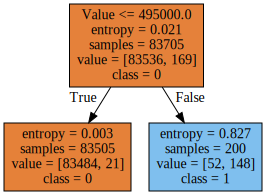

In [92]:
dtctrimmed = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)
dtctrimmed.fit(X, y)

print("Trimmed Decision Tree")
score = cross_validation_score_f1(dtctrimmed, X, y, 8)
print("Cross-validated F1 score: {}".format(score))

graph = Source(tree.export_graphviz(dtctrimmed, out_file=None
   , feature_names=features, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

## Conclusions
- By limiting the depth of the decision tree to a single layer, we can see that the same score can be achieved by simply predicting that all withdrawals over 495000UGX are fraudulent. 
- This suggests that there is no further predictive power to be found in any of the wide range of additional engineered features
- I suspect based on this analysis that unless it is possible to engineer better features not considered here, any score higher than 0.7 attained on the competition leaderboard is due to luck rather than predictive power.

### Output csv file for competition submission

In [57]:
test_preds = dtc.predict(X_test)
output = pd.DataFrame()
test = pd.read_csv('test.csv')
output['TransactionId'] = test['TransactionId']
output['FraudResult'] = test_preds
output.to_csv('submission.csv', index=False)